为了能够更加方便测试数据集合，比较各个算法模型的优劣，构建一个竞技场。目前主要支持4个平台的测试：

- arsenal
- sklearn
- spark mllib
- tensorflow


In [1]:
# Package imports
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

import eipi10.ml.neural_network as nn
import eipi10.ml.linear_model as lm
from eipi10.ml.planar_utils import *
from eipi10.ml.utils import *
from eipi10.test.testCases_v2 import *
from eipi10.ml.predictor import ClassificationPredictor
import logging

%matplotlib inline

# 1. 数据

train_X_orig.shape=(2, 300)
train_Y_orig.shape=(1, 300)
test_X_orig.shape=(2, 100)
test_Y_orig.shape=(1, 100)


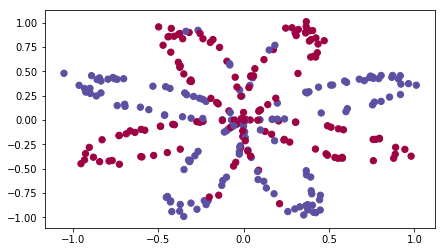

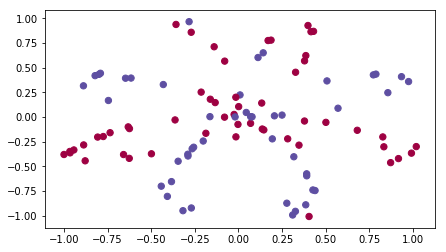

In [2]:
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

train_X_orig, train_Y_orig, test_X_orig, test_Y_orig = load_petal_dataset()
print("train_X_orig.shape={}".format(train_X_orig.shape))
print("train_Y_orig.shape={}".format(train_Y_orig.shape))
print("test_X_orig.shape={}".format(test_X_orig.shape))
print("test_Y_orig.shape={}".format(test_Y_orig.shape))

# Visualize train data
plt.scatter(train_X_orig.T[:, 0], train_X_orig.T[:, 1], c=train_Y_orig.T, s=40, cmap=plt.cm.Spectral)
plt.show()
plt.scatter(test_X_orig.T[:, 0], test_X_orig.T[:, 1], c=test_Y_orig.T, s=40, cmap=plt.cm.Spectral)

# 2. arsenal 

## 2.1 Logistic Regression


- 尝试不同的degree， 发现  
    - degree=1: 线性分类，无法分开
    - degree=2: 一个弧线无法分开
    - degree>3: 能够达到80%的准确率，但几乎无法进一步提高了
 
    
- 尝试不同的learning_rate, 但几乎无法进一步提高了
    

INFO: Cost after epoch 0: 0.6931471806


train_X.shape=(9, 300)
train_Y.shape=(1, 300)
test_X.shape=(9, 100)
test_Y.shape=(1, 100)


INFO: Cost after epoch 50: 0.6250545419
INFO: Cost after epoch 100: 0.5990386542
INFO: Cost after epoch 150: 0.5792267448
INFO: Cost after epoch 200: 0.5633189829
INFO: Cost after epoch 250: 0.5502733065
INFO: Cost after epoch 300: 0.5394194607
INFO: Cost after epoch 350: 0.5302869838
INFO: Cost after epoch 400: 0.5225292107
INFO: Cost after epoch 450: 0.5158830239
INFO: Final Cost after epoch 500: 0.5101448880


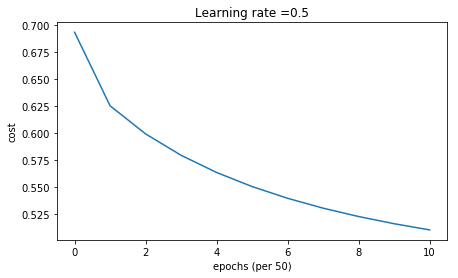

train accuracy: 0.8033333333333333
dev accuracy: 0.79


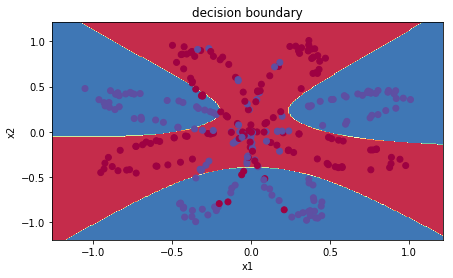

In [3]:
reload(lm)

train_X, train_Y, test_X, test_Y =  (train_X_orig, train_Y_orig, test_X_orig, test_Y_orig)
degree=3
train_X = map_feature(train_X, degree)
test_X = map_feature(test_X, degree)

print("train_X.shape={}".format(train_X.shape))
print("train_Y.shape={}".format(train_Y.shape))
print("test_X.shape={}".format(test_X.shape))
print("test_Y.shape={}".format(test_Y.shape))

model = lm.LogisticRegression(num_features=train_X.shape[0], activator=Sigmoid,   
                              regularizer=L2Regularizer(0), iterator=NumberIterator(500), 
                              optimizer=GradientOptimizer(0.5), initializer=WeightInitializer(),
                              keep_cost_num_epoch=50)

model.fit(train_X, train_Y, print_cost=True, print_num_epoch=50)   
model.plot_costs()

predictor = ClassificationPredictor(model)
predictor.print_accuracy_train_test(train_X, train_Y, test_X, test_Y)
plot_decision_boundary_map_feature(predictor, train_X_orig, train_Y, degree=degree)

## 2.2 神经网络

### Round 1

Step 1
* learning rate($\alpha$) 是首要的需要调节的参数 :  算法能够很快的收敛，设定learning rate=0.025   
On the train set:  
Accuracy: 0.843333333333  
On the test set:  
Accuracy: 0.87  

Step 2
* $\beta $ for momentum. 0.9 is default  : 直接使用Adam了
* mini-batch size: 尝试了不同batch size, 发现性能变化不大
* hidden units：  调整神经元的个数，发现性能变化不大

Step 3
* layers  
    - num_neurons=[train_X.shape[0], 10, 4, 1],结果更糟。cost计算出现divide 0  
On the train set:  
Accuracy: 0.786666666667  
On the test set:  
Accuracy: 0.79  
    - num_neurons=[train_X.shape[0], 8, 4, 1], 结果提高非常明显，这点非常奇怪，神经元个数减少，性能为何大大提高  
On the train set:  
Accuracy: 0.9  
On the test set:  
Accuracy: 0.86  
    - num_neurons=[train_X.shape[0], 16, 8, 1], 结果近一步提高  
    On the train set:  
    Accuracy: 0.933333333333 
    On the test set:  
    Accuracy: 0.87  
* learning rate decay：   alpha = 0.01， mini_batch=100       
On the train set:  
Accuracy: 0.903333333333  
On the test set:  
Accuracy: 0.89  
* $\beta 1,  \beta 2, \epsilon$ for Adam

* 增加样本个数从400-2000， 性能显著提高  
On the train set:  
Accuracy: 0.931333333333  
On the test set:  
Accuracy: 0.924  


In [4]:

learning_rate = 0.025

#batch
epoch_times = 1000
mini_batch = 100
print_num_epoch = 50
keep_cost_num_epoch = 50

#initialize
static_weight_scale=10

#regularize
alpha = 0.01
keep_prob = 1

#optimize
beta=0.9
beta1=0.9
beta2=0.99
epsilon=1e-8

train_X, train_Y, test_X, test_Y =  (train_X_orig, train_Y_orig, test_X_orig, test_Y_orig)
# train_X, train_Y, test_X, test_Y = load_petal_dataset(num_example=2000) #增加样本，很明显提高了性能
num_neurons=[train_X.shape[0], 16, 8, 1]
activators=[Relu, Relu, Sigmoid]

INFO: Cost after epoch 0: 0.6473064309
INFO: Cost after epoch 50: 0.3562350815
INFO: Cost after epoch 100: 0.3014970147
INFO: Cost after epoch 150: 0.2801614307
INFO: Cost after epoch 200: 0.2716917284
INFO: Cost after epoch 250: 0.2554432626
INFO: Cost after epoch 300: 0.2315247508
/eipi10/python-book/arsenal/eipi10/ml/utils.py:99: RuntimeWarning: divide by zero encountered in log
  return -np.nansum(np.multiply(Y, np.log(A)) + np.multiply(1-Y, np.log(1-A)))/m
/eipi10/python-book/arsenal/eipi10/ml/utils.py:99: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(np.multiply(Y, np.log(A)) + np.multiply(1-Y, np.log(1-A)))/m
INFO: Cost after epoch 350: 0.2145109793
INFO: Cost after epoch 400: 0.2923089499
INFO: Cost after epoch 450: 0.1640177090
INFO: Cost after epoch 500: 0.2658767508
INFO: Cost after epoch 550: 0.2146026131
INFO: Cost after epoch 600: 0.2336110332
INFO: Cost after epoch 650: 0.2149426560
INFO: Cost after epoch 700: 0.3058017535
INFO: Cost after epo

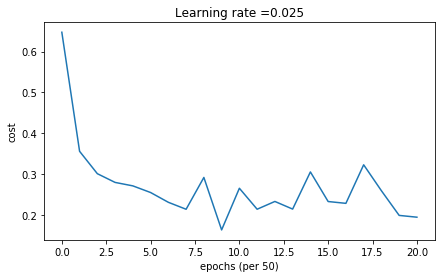

train accuracy: 0.9033333333333333
dev accuracy: 0.89


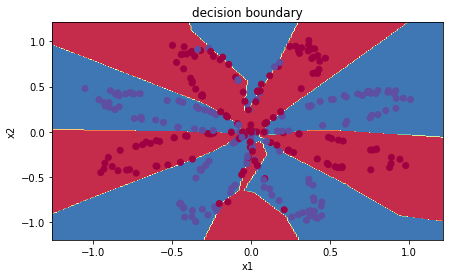

In [5]:
reload(nn)
model = nn.NeuralNetwork.build(
    num_neurons=num_neurons,
    activators=activators,      
    iterator=NumberIterator(epoch_times),
    initializer=HeWeightInitializer(),
    optimizer=nn.AdamOptimizer(learning_rate=learning_rate, beta1=beta1, beta2=beta2, epsilon=epsilon),
    keep_cost_num_epoch=keep_cost_num_epoch,
    mini_batch=mini_batch,
    regularizer=nn.L2Regularizer(alpha) ,
    keep_prob=keep_prob
)

model.fit(train_X, train_Y,  print_cost=True, print_num_epoch=print_num_epoch)
model.plot_costs()

predictor = ClassificationPredictor(model)
predictor.print_accuracy_train_test(train_X, train_Y, test_X, test_Y)
predictor.plot_decision_boundary(train_X, train_Y)


# 3. sklearn

##  3.1 Logistic Regression 

参见http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [6]:
from sklearn import linear_model
from sklearn import neighbors

train_X, train_Y, test_X, test_Y =  (train_X_orig, train_Y_orig, test_X_orig, test_Y_orig)
degree=2
train_X = map_feature(train_X, degree)
test_X = map_feature(test_X, degree)

model = linear_model.LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=50000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

logistic = model.fit(train_X.T, np.ravel(train_Y))
print(model.score(train_X.T, np.ravel(train_Y)))
print(model.score(test_X.T, np.ravel(test_Y)))


0.546666666667
0.49


knn = neighbors.KNeighborsClassifier()
knn = knn.fit(train_set_x.T, np.ravel(train_set_y))
print(knn.score(train_set_x.T, np.ravel(train_set_y)))
print(knn.score(test_set_x.T, np.ravel(test_set_y)))